In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import lightgbm as LGB
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, partial
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

config = {
    "font.family": 'serif',
    "font.size": 12,
    'font.sans-serif': 'Heiti TC'
}

from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams.update(config)


# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# plt.rcParams['font.sans-serif'] = ['Heiti TC']

In [ ]:
data = pd.read_csv('data1.csv', encoding = 'utf-8')
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing.plot.bar()
# 高缺失值的特征
miss = missing.index.tolist()
miss

In [222]:
data = pd.read_csv('data1.csv', encoding = 'utf-8')
data.rename(columns={'是否首日破发': 'label'}, inplace=True)
print(data.columns)
data.head(5)

Index(['证券代码', '统计截止日期', '招股开始日期', '货币资金', '交易性金融资产', '应收票据净额', '应收账款净额',
       '预付款项净额', '其他应收款净额', '存货净额',
       ...
       '研发费用', '政府补助', '营业收入.1', '上市日期.1', '开盘价', '最高价', '最低价', '收盘价',
       '最低价是否低于发行价', '收盘价是否低于发行价'],
      dtype='object', length=162)


,证券代码,统计截止日期,招股开始日期,货币资金,交易性金融资产,应收票据净额,应收账款净额,预付款项净额,其他应收款净额,存货净额,其他流动资产,流动资产合计,长期应收款净额,长期股权投资净额,投资性房地产净额,固定资产净额,在建工程净额,无形资产净额,商誉净额,长期待摊费用,递延所得税资产,其他非流动资产,非流动资产合计,资产总计,短期借款,应付票据,应付账款,预收款项,应付职工薪酬,应交税费,其他应付款,一年内到期的非流动负债,其他流动负债,流动负债合计,长期借款,长期应付款,长期负债合计,预计负债,递延所得税负债,其他非流动负债,非流动负债合计,负债合计,实收资本(或股本),资本公积,盈余公积,未分配利润,专项储备,归属于母公司所有者权益合计,少数股东权益,所有者权益合计,负债与所有者权益总计,营业总收入,营业收入,营业总成本,营业成本,营业税金及附加,销售费用,管理费用,财务费用,资产减值损失,投资收益,营业利润,营业外收入,营业外支出,利润总额,所得税费用,净利润,归属于母公司所有者的净利润,少数股东损益,基本每股收益,稀释每股收益,其他综合收益(损失),综合收益总额,归属于母公司所有者的综合收益总额,归属于少数股东的综合收益总额,销售商品、提供劳务收到的现金,客户存款和同业存放款项净增加额,经营活动现金流入小计,购买商品、接受劳务支付的现金,客户贷款及垫款净增加额,支付的各项税费,支付其他与经营活动有关的现金,经营活动现金流出小计,经营活动产生的现金流量净额,收回投资收到的现金,取得投资收益收到的现金,处置子公司及其他营业单位收到的现金净额,处置固定资产、无形资产和其他长期资产收回的现金净额,收到的其他与投资活动有关的现金,投资活动产生的现金流入小计,投资支付的现金,质押贷款净增加额,支付其他与投资活动有关的现金,投资活动产生的现金流出小计,投资活动产生的现金流量净额,吸收投资收到的现金,吸收权益性投资收到的现金,其中：子公司吸收少数股东投资收到的现金,取得借款收到的现金,发行债券收到的现金,收到其他与筹资活动有关的现金,筹资活动现金流入小计,偿还债务支付的现金,分配股利、利润或偿付利息支付的现金,其中：子公司支付给少数股东的股利、利润,支付其他与筹资活动有关的现金,筹资活动现金流出小计,筹资活动产生的现金流量净额,汇率变动对现金及现金等价物的影响,其他对现金的影响,期初现金及现金等价物余额,期末现金及现金等价物余额,归属于上市公司股东的扣除非经常性损益的净利润,非经常性损益,扣除非经常性损益后的基本每股收益,扣除非经常性损益后的稀释每股收益,加权平均净资产收益率,扣除非经常性损益后的加权平均净资产收益率,每股经营活动产生的现金流量净额,归属于上市公司股东的每股净资产,资产负债率,母公司资产负债率,流动比率,速动比率,应收账款周转率,存货周转率,息税折旧摊销前利润,利息保障倍数,无形资产(扣除土地使用权)占净资产比例,总资产周转率,每股净现金流量,招股日期,公司性质,是否有私募(或风投),第一大私募名称,第一大私募持股数,第一大私募持股比率(%),董事会成员数量,独立董事数量,董事长与总经理兼任情况,审计委员会成员数量,审计委员会独立董事数量,薪酬与考核委员会成员数量,薪酬与考核委员会独立董事数量,是否首次发行,上市日期,发行价格,会计年度,距上市日几年,当年获得专利数量,研发费用/营业收入,政府补助/营业收入,研发费用,政府补助,营业收入.1,上市日期.1,开盘价,最高价,最低价,收盘价,最低价是否低于发行价,收盘价是否低于发行价
0,333,2013/6/30,2013/9/17,1.792127e+07,540478.88,13386306.07,12540844.15,1962873.25,1076860.96,8.787525e+06,2154367.58,5.950730e+07,0.00,1685878.82,80865.789,1.958509e+07,1.548621e+06,3.509927e+06,3473028.5,547096.49,1967582.60,0.0,3.506475e+07,9.457205e+07,1.144493e+07,8205818.52,15930976.31,2724372.76,1062041.47,1790673.25,1677422.20,3288432.42,9983478.02,5.665478e+07,1400199.41,0.00,1560652.19,27583.980,108088.35,116342.33,1.812667e+06,5.846745e+07,1000000.0,3.018380e+06,66439.07,1.313747e+07,0.0,1.690972e+07,19194872.11,3.610460e+07,9.457205e+07,6.600663e+07,6.593948e+07,6.126045e+07,5.081856e+07,344871.74,6134252.63,3157978.59,621362.94,183418.31,437475.62,5.514980e+06,354675.47,147762.31,5.721894e+06,980052.69,4.741841e+06,2.646835e+06,2095006.34,2.65,2.65,-168451.58,4573389.5,2597845.3,1975544.0,0.0,4.447656e+07,1097569.73,4.735891e+07,2.460677e+07,4713708.27,3539645.08,8398101.86,43789546.9,3.569364e+06,1000.0,414878.02,91299.203,192402.45,0.0,699579.67,0.0,1.268894e+06,0.00,1.268894e+06,-5.693139e+05,11596.04,11596.04,0.0,1.673913e+07,0.0,0.0,1.675072e+07,13999678.3,1758519.71,0.0,577000.00,1.633520e+07,4.155241e+05,-10829.95,3.404744e+06,0.0,2.128116e+09,NaN,2.13,NaN,16.950001,13.630000,3.57,16.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2013/9/18,44.560001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013/9/18,40.500000,46.400002,39.880001,42.240002,1.0,1.0
1,1201,2018/12/31,2021/4/14,5.738171e+07,NaN,NaN,14349755.55,601021.16,7250362.38,1.102796e+08,192836.96,1.900553e+08,279298.34,29318068.72,NaN,3.078465e+08,2.526364e+07,4.339960e+06,11684098.0,7760344.33,657344.75,2667855.3,4.306659e+08,6.207211e+08,1.230000e+08,NaN,44687515.94,1041218.40,7183026.97,2045949.44,821281.62,22353940.35,NaN,2.011329e+08,30000000.00,23774413.12,53774413.12,NaN,NaN,NaN,9.277603e+07,2.939090e+08,95000000.0,1.717501e+08,11687683.25,4.837440e+07,NaN,3.268122e+08,NaN,3.268122e+08,6.207211e+08,6.136234e+08,6.136234e+08,6.080404e+08,5.099819e+08,1641816.64,37107287.54,43300462.66,10596350.99,1465223.50,1027079.31,1.285886e+07,125148.63,1452761.72,1.153125e+07,3470499.43,8.060746e+06,8.060746e+06,NaN,0.08,0.08,NaN,8060745.5,8060745.5,NaN,57381708.0,5.821665e+08,17432416.54,6.130812e+08,5.125268e+08,53308731.35,6218354.73,31471056.48,603524976.3,9.556176e+06,NaN,NaN,NaN,31316.07,NaN,31316.07,NaN,6.690900e+07,NaN,6.690900e+07,-6.687768e+07,NaN,NaN,NaN,1.230000e+08,NaN,59218200.0,1.822182e+08,128500000.0,16099685.89,NaN,2890099.42

In [234]:
data = pd.read_csv('data1.csv', encoding = 'utf-8')
data_info = ['证券代码','统计截止日期','招股开始日期','上市日期','上市日期.1','招股日期']
basic = ['公司性质', '第一大私募名称', '是否首次发行']
jiage = [ '开盘价','收盘价', '最高价', '最低价', '最低价是否低于发行价', '收盘价是否低于发行价',]
# 核密度图对比不对label不具有区分度的特征
drop_feature = ['长期股权投资净额',  '无形资产净额', '商誉净额', '其他应付款', '流动负债合计', '长期应付款', '其他非流动负债','资本公积', '归属于母公司所有者权益合计', '所有者权益合计',  '管理费用',  '归属于母公司所有者的净利润',   '归属于少数股东的综合收益总额',  '销售商品、提供劳务收到的现金',  '吸收权益性投资收到的现金']#'综合收益总额 ',' 归属于母公司所有者的综合收益总额', 
df = data.copy()
df['label'] = df.apply(lambda row: 1 if row['发行价格'] > row['开盘价'] else 0, axis=1)
df.drop(basic+jiage, axis = 1, inplace = True)
df[df['label'] == 1].head(5) # 1 为 436行

,证券代码,统计截止日期,招股开始日期,货币资金,交易性金融资产,应收票据净额,应收账款净额,预付款项净额,其他应收款净额,存货净额,其他流动资产,流动资产合计,长期应收款净额,长期股权投资净额,投资性房地产净额,固定资产净额,在建工程净额,无形资产净额,商誉净额,长期待摊费用,递延所得税资产,其他非流动资产,非流动资产合计,资产总计,短期借款,应付票据,应付账款,预收款项,应付职工薪酬,应交税费,其他应付款,一年内到期的非流动负债,其他流动负债,流动负债合计,长期借款,长期应付款,长期负债合计,预计负债,递延所得税负债,其他非流动负债,非流动负债合计,负债合计,实收资本(或股本),资本公积,盈余公积,未分配利润,专项储备,归属于母公司所有者权益合计,少数股东权益,所有者权益合计,负债与所有者权益总计,营业总收入,营业收入,营业总成本,营业成本,营业税金及附加,销售费用,管理费用,财务费用,资产减值损失,投资收益,营业利润,营业外收入,营业外支出,利润总额,所得税费用,净利润,归属于母公司所有者的净利润,少数股东损益,基本每股收益,稀释每股收益,其他综合收益(损失),综合收益总额,归属于母公司所有者的综合收益总额,归属于少数股东的综合收益总额,销售商品、提供劳务收到的现金,客户存款和同业存放款项净增加额,经营活动现金流入小计,购买商品、接受劳务支付的现金,客户贷款及垫款净增加额,支付的各项税费,支付其他与经营活动有关的现金,经营活动现金流出小计,经营活动产生的现金流量净额,收回投资收到的现金,取得投资收益收到的现金,处置子公司及其他营业单位收到的现金净额,处置固定资产、无形资产和其他长期资产收回的现金净额,收到的其他与投资活动有关的现金,投资活动产生的现金流入小计,投资支付的现金,质押贷款净增加额,支付其他与投资活动有关的现金,投资活动产生的现金流出小计,投资活动产生的现金流量净额,吸收投资收到的现金,吸收权益性投资收到的现金,其中：子公司吸收少数股东投资收到的现金,取得借款收到的现金,发行债券收到的现金,收到其他与筹资活动有关的现金,筹资活动现金流入小计,偿还债务支付的现金,分配股利、利润或偿付利息支付的现金,其中：子公司支付给少数股东的股利、利润,支付其他与筹资活动有关的现金,筹资活动现金流出小计,筹资活动产生的现金流量净额,汇率变动对现金及现金等价物的影响,其他对现金的影响,期初现金及现金等价物余额,期末现金及现金等价物余额,归属于上市公司股东的扣除非经常性损益的净利润,非经常性损益,扣除非经常性损益后的基本每股收益,扣除非经常性损益后的稀释每股收益,加权平均净资产收益率,扣除非经常性损益后的加权平均净资产收益率,每股经营活动产生的现金流量净额,归属于上市公司股东的每股净资产,资产负债率,母公司资产负债率,流动比率,速动比率,应收账款周转率,存货周转率,息税折旧摊销前利润,利息保障倍数,无形资产(扣除土地使用权)占净资产比例,总资产周转率,每股净现金流量,招股日期,是否有私募(或风投),第一大私募持股数,第一大私募持股比率(%),董事会成员数量,独立董事数量,董事长与总经理兼任情况,审计委员会成员数量,审计委员会独立董事数量,薪酬与考核委员会成员数量,薪酬与考核委员会独立董事数量,上市日期,发行价格,会计年度,距上市日几年,当年获得专利数量,研发费用/营业收入,政府补助/营业收入,研发费用,政府补助,营业收入.1,上市日期.1,label
0,333,2013/6/30,2013/9/17,1.792127e+07,540478.88,13386306.07,12540844.15,1962873.25,1.076861e+06,8.787525e+06,2154367.58,5.950730e+07,0.0,1685878.82,80865.789,1.958509e+07,1.548621e+06,3509926.96,3473028.5,547096.49,1967582.600,0.0,3.506475e+07,94572048.7,11444927.78,8.205819e+06,15930976.31,2724372.76,1062041.47,1790673.25,1677422.20,3288432.42,9983478.02,5.665478e+07,1.400199e+06,0.0,1.560652e+06,27583.98,108088.35,116342.33,1.812667e+06,5.846745e+07,1000000.0,3.018380e+06,66439.07,1.313747e+07,0.0,1.690972e+07,19194872.11,3.610460e+07,94572048.7,6.600663e+07,6.593948e+07,6.126045e+07,5.081856e+07,344871.74,6134252.63,3157978.59,621362.94,1.834183e+05,437475.62,5.514980e+06,354675.47,147762.31,5.721894e+06,980052.69,4.741841e+06,2.646835e+06,2095006.34,2.65,2.65,-168451.58,4573389.5,2597845.3,1975544.0,0.0,4.447656e+07,1097569.73,4.735891e+07,2.460677e+07,4713708.27,3539645.08,8398101.86,4.378955e+07,3.569364e+06,1000.0,414878.02,91299.203,192402.45,0.0,6.995797e+05,0.0,1.268894e+06,0.0,1.268894e+06,-5.693139e+05,11596.04,11596.04,0.0,1.673913e+07,0.0,0.0,1.675072e+07,13999678.3,1758519.71,0.0,5.770000e+05,1.633520e+07,4.155241e+05,-10829.95,3.404744e+06,0.0,2.128116e+09,NaN,2.13,NaN,16.950001,13.630000,3.57,16.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013/9/18,44.560001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013/9/18,1
3581,300834,2021/9/30,2022/1/4,2.095937e+08,NaN,NaN,NaN,45436875.50,4.644845e+05,9.798229e+07,2182210.49,3.556595e+08,NaN,NaN,NaN,3.504708e+08,7.160238e+07,52306920.80,NaN,5479808.04,25073.320,28894922.0,5.087799e+08,864439413.8,NaN,6.500000e+07,28834593.16,NaN,2045161.93,18837422.13,17356.00,NaN,3724299.65,1.471073e+08,NaN,NaN,NaN,NaN,NaN,NaN,2.863701e+06,1.499710e+08,145284253.0,1.102069e+08,45440871.19,4.104054e+08,3131029.8,7.144684e+08,NaN,7.144684e+08,864439413.8,1.461079e+09,1.461079e+09,1.192304e+09,1.125618e+09,6504579.45,1197218.12,11110344.39,-1770384.91,3.959600e+02,66653.15,2.739852e+08,1828844.71,NaN,2.758141e+08,39583601.25,2.362305e+08,2.362305e+08,NaN,1.63,1.63,NaN,236230464.0,NaN,NaN,196481136.0,1.666412e+09,15510099.09,1.681922e+09,1.275473e+09,17405465.60,89780620.27,48079736.85,1.430739e+09,2.511830e+08,59000000.0,66653.15,NaN,NaN,NaN,5.906665e+07,59000000.0,8.562088e+07,NaN,1.446209e+08,-8.555423e+07,NaN,NaN,NaN,NaN,NaN,10940000.0,1.094000e+07,NaN,402551.66,NaN,2.195509e+07,2.235765e+07,-1.141765e+07,-36.87,1.542111e+08,42270016.0,2.302549e+08,5975519.69,1.58,1.58,39.650002,38.639999,1.73,NaN,NaN,17.350000,2.42,1.43,NaN,NaN

In [236]:
# pd.to_datetime(data['招股开始日期']) - data['统计截止日期'] 
df_1 = df[df['label'] == 1]
df_0 = df[df['label'] == 0]
df_0['ss_data'] = pd.to_datetime(df_0['招股开始日期'], format =  "%Y/%m/%d")
df_0['ddl_data'] = pd.to_datetime(df_0['统计截止日期'],format =  "%Y/%m/%d")
df_0['time_diff'] = df_0['ss_data'] -  df_0['ddl_data']
# df[df['上市日期'] == '2022-00-00']
df_0 = df_0.loc[df_0.groupby("证券代码")["ddl_data"].idxmax()]
df_new = pd.concat([df_0, df_1] ,axis = 0)
# df.drop(basic+jiage+drop_feature, axis = 1, inplace = True)
df_new['统计截止日期format'] = pd.to_datetime(df_new['统计截止日期'], format =  "%Y/%m/%d")
df_new['招股开始日期format'] = pd.to_datetime(df_new['招股开始日期'], format =  "%Y/%m/%d")
df_new['招股日期format'] = pd.to_datetime(df_new['招股日期'], format =  "%Y/%m/%d")
df_new['统计截止日期-招股开始日期'] = df_new['招股开始日期format'] - df_new['统计截止日期format']
df_new['统计截止日期-招股开始日期'] = df_new['统计截止日期-招股开始日期'].dt.days
df_new.drop(data_info+['ss_data', 'ddl_data', 'time_diff', '统计截止日期format', '招股开始日期format', '招股日期format'], axis = 1, inplace = True)
X = df_new.copy()
print( 'label = 0 样本个数：{}\nlabel = 1 样本个数：{} '.format(X[X['label'] == 0].shape[0],X[X['label'] == 1].shape[0]))

label = 0 样本个数：2520
label = 1 样本个数：427 


In [237]:
# df = pd.read_csv('data4.csv')
# df.rename(columns={'首日是否破发': 'label'}, inplace=True)
# # columns_to_convert = ['pos ratio', 'neg ratio']
# # df[columns_to_convert] = df[columns_to_convert].astype(float)
# X = df.copy()
# X.head(5)

In [238]:
X[X['label'] == 0]
X.shape

(2947, 149)

In [239]:
# 特征检查
feature_ls = X.columns.tolist()
feature_ls

['货币资金',
 '交易性金融资产',
 '应收票据净额',
 '应收账款净额',
 '预付款项净额',
 '其他应收款净额',
 '存货净额',
 '其他流动资产',
 '流动资产合计',
 '长期应收款净额',
 '长期股权投资净额',
 '投资性房地产净额',
 '固定资产净额',
 '在建工程净额',
 '无形资产净额',
 '商誉净额',
 '长期待摊费用',
 '递延所得税资产',
 '其他非流动资产',
 '非流动资产合计',
 '资产总计',
 '短期借款',
 '应付票据',
 '应付账款',
 '预收款项',
 '应付职工薪酬',
 '应交税费',
 '其他应付款',
 '一年内到期的非流动负债',
 '其他流动负债',
 '流动负债合计',
 '长期借款',
 '长期应付款',
 '长期负债合计',
 '预计负债',
 '递延所得税负债',
 '其他非流动负债',
 '非流动负债合计',
 '负债合计',
 '实收资本(或股本)',
 '资本公积',
 '盈余公积',
 '未分配利润',
 '专项储备',
 '归属于母公司所有者权益合计',
 '少数股东权益',
 '所有者权益合计',
 '负债与所有者权益总计',
 '营业总收入',
 '营业收入',
 '营业总成本',
 '营业成本',
 '营业税金及附加',
 '销售费用',
 '管理费用',
 '财务费用',
 '资产减值损失',
 '投资收益',
 '营业利润',
 '营业外收入',
 '营业外支出',
 '利润总额',
 '所得税费用',
 '净利润',
 '归属于母公司所有者的净利润',
 '少数股东损益',
 '基本每股收益',
 '稀释每股收益',
 '其他综合收益(损失)',
 '综合收益总额',
 '归属于母公司所有者的综合收益总额',
 '归属于少数股东的综合收益总额',
 '销售商品、提供劳务收到的现金',
 '客户存款和同业存放款项净增加额',
 '经营活动现金流入小计',
 '购买商品、接受劳务支付的现金',
 '客户贷款及垫款净增加额',
 '支付的各项税费',
 '支付其他与经营活动有关的现金',
 '经营活动现金流出小计',
 '经营活动产生的现金流量净额',
 '收回投资收到的现金',
 '取得投资收益收到的现金',
 '处置子公司及其他营业单位收到的现金

In [240]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 假设你的数据存储在一个DataFrame中，特征名为"feature"，标签名为"label"
# # 请根据你的数据实际情况进行调整

# # 分离标签为0和标签为1的数据
# data_label_0 = df[df["label"] == 0]
# data_label_1 = df[df["label"] == 1]

# for i in feature_ls[:100]:
#     # 设置图形大小
#     plt.rcParams['font.sans-serif'] = ['Heiti TC']
#     plt.figure(figsize=(10, 6))

#     # 在标签为0的数据上绘制核密度曲线

#     sns.kdeplot(data_label_0.dropna(subset=[i])[i], label="Label 0",color = 'cyan', linewidth = 1)

#     # 在标签为1的数据上绘制核密度曲线
#     sns.kdeplot(data_label_1.dropna(subset=[i])[i].dropna(), label="Label 1", color = 'red', linewidth = 0.5)

#     # 添加标题和标签
#     plt.title("Kernel Density Plot of Feature by Label")
#     print(i)
#     plt.ylabel("Density")
#     plt.xlim(-1e10,1e10)

#     # 显示图例
#     plt.legend()

#     # 显示图形
#     plt.show()

In [241]:
features = X.drop(['label'],axis = 1)
label = X['label'] # 500个1 10500个0

In [ ]:
# 标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_standardized = scaler.fit_transform(X)
df_standardized = pd.DataFrame(df_standardized, columns=X.columns)

In [242]:
from sklearn.model_selection import train_test_split

# 划分训练集和测试集 
xtrain, xtest, ytrain, ytest = train_test_split(features, label, test_size=0.2, random_state=42)

# 再从训练集中划分出验证集
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.15, random_state=42)
print('训练集合样本个数{},label = 1 样本比率：{}\n验证集样本个数{},label = 1 样本比率：{}\n测试集样本个数{},label = 1 样本比率：{}'.format(xtrain.shape[0],ytrain[ytrain == 1].shape[0]/(ytrain[ytrain == 1].shape[0] + ytrain[ytrain == 0].shape[0]),
                                                                                 xval.shape[0],ytest[ytest == 1].shape[0]/(ytest[ytest == 1].shape[0]+ytest[ytest == 0].shape[0])
                                                                                 ,xtest.shape[0],yval[yval == 1].shape[0]/(yval[yval == 0].shape[0]+yval[yval == 1].shape[0])))

训练集合样本个数2003,label = 1 样本比率：0.14827758362456314
验证集样本个数354,label = 1 样本比率：0.13898305084745763
测试集样本个数590,label = 1 样本比率：0.13559322033898305


In [243]:
print(xtrain.shape[1], xval.shape[1])

148 148


In [244]:
# 定义f1 score
def f1_metric(preds, train_data):
    
    labels = train_data.get_label()
    y_pred = np.round(preds)
    
    return 'f1', f1_score(labels,y_pred), True
# 精筛
feature_importance_list = []
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'none'}, # binary_error / auc
    'learning_rate': 0.01,
    'random_state': 42,
    'nthread': 8,
    'verbose': -1
}

for ti, vi in cv.split(xtrain, ytrain):
    xt, xv = xtrain.iloc[ti], xtrain.iloc[vi],
    yt, yv = ytrain.iloc[ti], ytrain.iloc[vi],
    print(xt.shape[1], xv.shape[1])
    lgb_train = LGB.Dataset(xt, yt)
    lgb_eval = LGB.Dataset(xv,
                           yv,
                           reference=lgb_train)
    # 召回评估值
    log_callback = LGB.log_evaluation(period=100)
    # 早停回调函数
    early_stopping = LGB.early_stopping(100)
    # 开始模型训练
    lgb = LGB.train(params,
                    lgb_train, # 训练集合
                    num_boost_round=800, # 迭代轮次，越多越过拟合
                    valid_sets=lgb_eval, # 验证集
                    callbacks=[log_callback, early_stopping], # 返回信息
                    feval = f1_metric
                    
            )
    feature_importance_list.append(lgb.feature_importance()) # 返回特征重要性

148 148
Training until validation scores don't improve for 100 rounds
[100]	valid_0's f1: 0.708333
[200]	valid_0's f1: 0.814815
Early stopping, best iteration is:
[190]	valid_0's f1: 0.814815
148 148
Training until validation scores don't improve for 100 rounds
[100]	valid_0's f1: 0.8
[200]	valid_0's f1: 0.846154
[300]	valid_0's f1: 0.888889
Early stopping, best iteration is:
[254]	valid_0's f1: 0.888889
148 148
Training until validation scores don't improve for 100 rounds
[100]	valid_0's f1: 0.734694
[200]	valid_0's f1: 0.814815
[300]	valid_0's f1: 0.896552
Early stopping, best iteration is:
[284]	valid_0's f1: 0.912281
148 148
Training until validation scores don't improve for 100 rounds
[100]	valid_0's f1: 0.765957
[200]	valid_0's f1: 0.84
Early stopping, best iteration is:
[172]	valid_0's f1: 0.84
148 148
Training until validation scores don't improve for 100 rounds
[100]	valid_0's f1: 0.823529
[200]	valid_0's f1: 0.872727
Early stopping, best iteration is:
[144]	valid_0's f1: 0.87

In [267]:
# 设置 Pandas 输出选项，以显示所有行和列
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# 选一个验证集表现最好的模型
y_pred = lgb.predict(xval, num_iteration=lgb.best_iteration) 
xval.shape[1], xtrain.shape[1]
y_pred = pd.DataFrame(y_pred, columns = ['label'])
y_pred['pre'] = y_pred['label'].apply(lambda x: 1 if x > 0.1 else 0)
y_val = pd.DataFrame(yval)
y_val = y_val.reset_index()
y_pred['y_val'] = y_val['label']
y_pred[y_pred['y_val'] == 1]['pre'].mean()
print('label = 0被预测错误的概率：',y_pred[y_pred['y_val'] == 0]['pre'].mean())
print('label = 1被预测正确的概率：',y_pred[y_pred['y_val'] == 1]['pre'].mean())

label = 0被预测错误的概率： 0.10457516339869281
label = 1被预测正确的概率： 0.8958333333333334


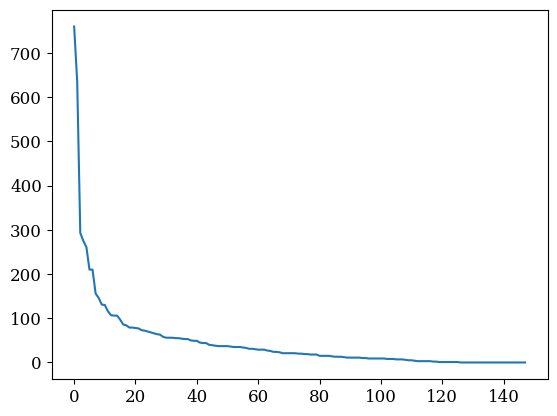

In [268]:
import matplotlib.pyplot as plt

d = {
    'feature': lgb.feature_name(),
    'importance': lgb.feature_importance()
}
res = pd.DataFrame(d).sort_values('importance', ascending=False)
plt.plot(range(len(res)), res['importance'])

In [269]:
columns = res['feature'][:30].to_list()
# xtrain = xtrain[columns]
columns

['发行价格',
 '统计截止日期-招股开始日期',
 '未分配利润',
 '筹资活动现金流出小计',
 '营业外收入',
 '会计年度',
 '资产减值损失',
 '应收票据净额',
 '递延所得税资产',
 '一年内到期的非流动负债',
 '应收账款净额',
 '投资支付的现金',
 '其他流动负债',
 '盈余公积',
 '预收款项',
 '实收资本(或股本)',
 '非经常性损益',
 '应收账款周转率',
 '第一大私募持股数',
 '其他对现金的影响',
 '存货净额',
 '吸收投资收到的现金',
 '管理费用',
 '少数股东权益',
 '第一大私募持股比率(%)',
 '其他综合收益(损失)',
 '长期负债合计',
 '资产负债率',
 '流动资产合计',
 '母公司资产负债率']

In [270]:
res[0:30].reset_index()

,index,feature,importance
0,138,发行价格,760
1,147,统计截止日期-招股开始日期,635
2,42,未分配利润,293
3,103,筹资活动现金流出小计,275
4,59,营业外收入,261
5,139,会计年度,210
6,56,资产减值损失,210
7,2,应收票据净额,156
8,17,递延所得税资产,146
9,28,一年内到期的非流动负债,131


In [271]:
lgb.feature_importance()

array([  9,  53, 156, 130,  20,  55,  78,  35,  63,   0,  29,   3,  10,
        31,  21,   0,  38, 146,  45,   1,  15,  15,   3,  10, 106,  24,
        26,  56, 131, 107,  24,   9,  37,  66,  21,  40,   0,   9,  19,
        97,  50, 106, 293,   0,  11,  72,   0,   0,   2,   0,   7,  15,
         5,  37,  73,  18, 210,  34,   4, 261,  36,   1,  33,   5,   8,
        20,  13,  15,  68,  13,  27,  12,  39,   0,  35,   8,  11,   9,
         2,  29,   8,  49,  49,  56,   0,  21,  14, 116,   3,   6,   7,
        18,  77,   1,  13,   0,  56,   0,   9,  21,  35,  11,   0, 275,
        19,  53,  79,  29,  54,  44,  86,  55,  37,  21,  11,  37,  31,
        64,  58,   1,   7,  84,  11,   1,  30,  44,   0,  18,   0,  79,
        70,  23,   0,   9,   0,   0,   0,   1, 760, 210,   0,   0,   3,
         3,   0,   1,   0, 635], dtype=int32)

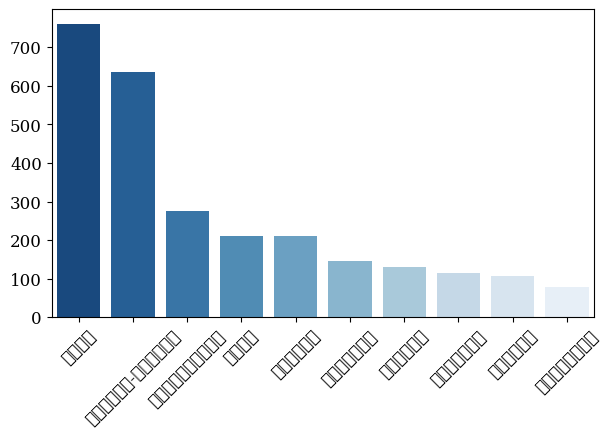

In [273]:
plt.rcParams['font.sans-serif'] = ['Heiti TC']
plt.figure(figsize=(7, 4))
s = sns.barplot(x="feature", y="importance", 
                data=res.iloc[[0, 1, 3, 5, 6, 8, 10, 11, 12, 19]], palette="Blues_r")
s.set_xlabel('')
s.set_ylabel('')
s.set_xticklabels(s.get_xticklabels(), rotation=45)
plt.savefig('Importance', bbox_inches = 'tight')
plt.show()

In [ ]:
params = {
    'objective': 'binary',  # 二分类任务
    'metric': 'binary_logloss',  # 使用对数损失进行评估
    'boosting_type': 'gbdt',  # 梯度提升树
    'learning_rate': 0.01,  # 学习率
    'num_leaves': 31,  # 每棵树的叶子节点数
    'max_depth': -1,  # 树的最大深度，-1 表示不限制
    'min_data_in_leaf': 20,  # 叶子节点上的最少样本数
}



In [284]:
#LGB树展示
from sklearn import tree
import pydotplus
import graphviz
import os
dot_data=LGB.create_tree_digraph(lgb,tree_index=0)
dot_data.format='PDF'
dot_data.render('lgb_iris_0.pdf')



'lgb_iris_0.pdf.pdf'